In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_beh'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
%%time
pyr_ind_all = {}
int_ind_all = {}
cell_cols_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        pyr_ind_all[ani,sess]=res['cell_cols_d']['pyr']
        int_ind_all[ani,sess]=res['cell_cols_d']['int']
        cell_cols_d_all[ani,sess] = res['cell_cols_d']
celltype_ind_all = {'pyr':pyr_ind_all,'int':int_ind_all}

CPU times: user 8.57 s, sys: 4.92 s, total: 13.5 s
Wall time: 48.2 s


In [6]:
def get_ei_var_spk_beh_df(spk_beh_df,cell_cols_d):
    pyr_df = spk_beh_df[cell_cols_d['pyr']]
    int_df = spk_beh_df[cell_cols_d['int']]
    res_df={}
    res_df['E_mean'] = pyr_df.mean(axis=1)
    res_df['I_mean'] = int_df.mean(axis=1)
    res_df['E/I_mean'] = res_df['E_mean'] / res_df['I_mean']
    res_df['E_frac_active'] = (pyr_df>0).mean(axis=1)
    res_df['I_frac_active'] = (int_df>0).mean(axis=1)
    eps = 1e-10
    res_df['E/I_frac_active'] = res_df['E_frac_active']/(res_df['I_frac_active']+eps)
    res_df = pd.concat(res_df,axis=1)
    
    return res_df

In [7]:
def get_ei_var_spk_beh_df_all(spk_beh_df_all,cell_cols_d_all):
    ei_res_df_all = []
    for k,sbd in spk_beh_df_all.groupby(level=(0,1)):
        ei_res_df=get_ei_var_spk_beh_df(sbd,cell_cols_d_all[k])
        ei_res_df_all.append(ei_res_df)
    ei_res_df_all  = pd.concat(ei_res_df_all,axis=0)
    return ei_res_df_all

In [81]:
all_fields_recombined_all

start end com peak    fr_peak  \
                                   field_index                                 
e13_26m1 e13_26m1_210913 0 0.0  3  0              24  40  32   32   2.327171   
                                27 0               0  30  15   15  27.438358   
                                29 0               2   9   5    6   5.685168   
                                   1              20  38  29   30   22.52481   
                                   2              69  85  77   78  13.938965   
...                                              ...  ..  ..  ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0               6  23  14   13   6.647433   
                                32 0               5  26  15   18   7.859794   
                                38 0               0   7   2    0   5.592037   
                                47 0               4  10   7    7    3.72037   
                                53 0               0   6   2    4   2.114954   

                                                  fr_mean  other_field_index  
                                   field_index                                
e13_26m1 e13_26m1_210913 0 0.0  3  0             1.246869                NaN  
                                27 0            21.794745                NaN  
                                29 0             5.262314                NaN  
                                   1            14.049665                NaN  
                                   2             9.956611                NaN  
...                                                   ...                ...  
e14_2m3  e14_2m3_201118  0 both 30 0             4.711355                0.0  
                                32 0             6.384746                0.0  
                                38 0             3.799054                0.0  
                                47 0             3.481984                0.0  
                                53 0             2.088343                0.0  

[14438 rows x 7 columns]

In [8]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

best_n_all=prepped_data_agg['best_n_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [12]:
%%time
ei_res_df_all = []
for k,sbd in spk_beh_df_all.groupby(level=(0,1)):
    ei_res_df=get_ei_var_spk_beh_df(sbd,cell_cols_d_all[k])
    ei_res_df_all.append(ei_res_df)
ei_res_df_all  = pd.concat(ei_res_df_all,axis=0)

CPU times: user 14.9 s, sys: 7.13 s, total: 22 s
Wall time: 22 s


In [9]:
var_res_all_test['fit_var_ratio_1cp'] = pval_all[1]['exp_var_ratio']
var_res_all_test['fit_var_ratio_div_sh_1cp'] = pval_all[1]['exp_var_ratio'] / pval_all[1]['exp_var_ratio_sh_med']


In [10]:
import variability_axis as va
reload(va)

<module 'variability_axis' from '/mnt/home/szheng/projects/place_variability/code/variability_axis.py'>

In [11]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# prep data

In [12]:
import behavior_and_switching as bas
reload(bas)

<module 'behavior_and_switching' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py'>

In [13]:
trial_index_to_index_within_df_all = prepped_data_agg['trial_index_to_index_within_df_all']


In [ ]:
# n_field_per_pos_one_tt_per_trial_all=bas.get_n_fied_per_pos_per_trial_all(all_fields_recombined_all,trial_index_to_index_within_df_all,
#                                      var_bin_d={'lin_binned':np.array([0,15,74,111,185,202,222])/2.2},
#                                         combine_first_last_section=True,
#                                      pf_key = 'peak'
#                                     )

In [22]:
# var_per_trial_pos_all_re_nfield=var_per_trial_pos_all.set_index(['trial','lin_binned_cat'],append=True)
# var_per_trial_pos_all_re_nfield['n_field']  = n_field_per_pos_one_tt_per_trial_all.droplevel(3)


In [14]:
import behavior_and_switching as bas
reload(bas)

var_per_trial_pos_all = bas.prep_regression(spk_beh_df_all,all_fields_recombined_all,all_sw_d_all,trial_index_to_index_within_df_all,cell_cols_d_all=cell_cols_d_all,
                                                            var_bin_d={'lin_binned':np.array([0,15,74,111,185,202,222])/2.2},    
                                                            combine_first_last_section=True)



/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k_cat] = pd.cut(df[k],val,retbins=False,labels=False,include_lowest=True)
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.

/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_vari

/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_vari

In [41]:
# # check n field assignment correct
# gpb=n_field_per_pos_one_tt_per_trial_all.groupby(level=(0,1,2,3,4))
# for k,val in gpb:
#     ani,sess,ti,tt,trial_ind=k

# var_per_trial_pos_all.loc[ani,sess,ti].query('trial==@trial_ind')[['trial','lin_binned_cat','n_field']]

In [149]:
reload(bas)

<module 'behavior_and_switching' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py'>

In [147]:
# %%time
# correct_df_all = bas.get_correct_df_all(spk_beh_df_all,ti=0) 

CPU times: user 6.5 s, sys: 1.76 s, total: 8.26 s
Wall time: 8.25 s


##### left right trial averaged
count sw, per trial; sum across trials

In [18]:
y_key =  'sw_on'
y_key_l = ['sw_on','sw_off']
# n_sw_per_pos=var_per_trial_pos_all.set_index('lin_binned_cat',append=True).groupby(level=(0,1,2,3))[y_key_l].sum()
n_sw_per_pos = var_per_trial_pos_all.groupby(level=(0,1,2)).apply(lambda x:x.groupby('lin_binned_cat',group_keys=False)[y_key_l].sum())

n_field_per_pos=var_per_trial_pos_all.groupby(level=(0,1,2)).apply(lambda x:x.groupby('lin_binned_cat',group_keys=False)['n_field'].mean()).stack()

# n_field_per_pos=var_per_trial_pos_all.set_index('lin_binned_cat',append=True).groupby(level=(0,1,2,3))['n_field'].mean()

n_field_per_pos = pd.DataFrame(n_field_per_pos.values,index=n_field_per_pos.index,columns=['n_field'])

var_per_pos = pd.concat([n_sw_per_pos,n_field_per_pos],axis=1)

var_per_pos=var_per_pos.reset_index('lin_binned_cat')
var_per_pos['lin_binned_cat'] = var_per_pos['lin_binned_cat'].astype('category')

In [19]:
# normalize by n field
for y_key in y_key_l:
    var_per_pos[f'{y_key}_div_n_field'] = var_per_pos[y_key] / var_per_pos['n_field']
#     var_per_trial_pos_all[f'{y_key}_div_n_field'] = var_per_trial_pos_all[y_key] / var_per_trial_pos_all['n_field']

# spatial agg

In [63]:
import behavior_and_switching_plot as basp
reload(basp)

<module 'behavior_and_switching_plot' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching_plot.py'>

In [25]:
# sns.set_context('paper')
sns.reset_orig()

In [64]:
segment_names =['delay zone','central','T','return side','return pre delay zone']

In [119]:
reload(basp)

<module 'behavior_and_switching_plot' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching_plot.py'>

In [152]:
var_per_pos.index.get_level_values(1).nunique()

46

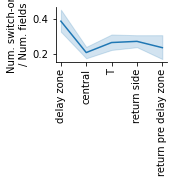

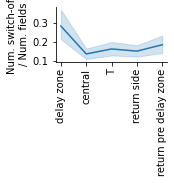

In [236]:
for onoff in ['on','off']:
    fig,ax=plt.subplots(figsize=(2,1))
    sns.lineplot(data=var_per_pos.reset_index(drop=True),x='lin_binned_cat',y=f'sw_{onoff}_div_n_field',ax=ax)
    ax.set_ylabel(f'Num. switch-{onoff}\n/ Num. fields')
    ax.set_xticks(np.arange(len(segment_names)))
    ax.set_xticklabels(segment_names,rotation=90)
    ax.set_xlabel('')
    figfn = f'n_sw_{onoff}_div_n_field_vs_pos'
    ph.save_given_name(fig,figfn,figdir)

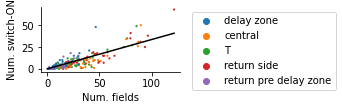

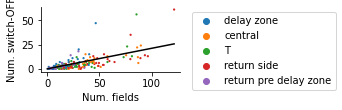

In [225]:
# this one seems uninformative, not using
x_key='n_field'
for onoff in ['on','off']:
    y_key=f'sw_{onoff}'
    hue='lin_binned_cat'
    fig,ax=basp.plot_scatter_with_slope(var_per_pos,x_key,y_key,hue,legend_text=segment_names,figsize=(2.5,1.2))
    ax.set_ylabel(f'Num. switch-{onoff.upper()}')
    ax.set_xlabel('Num. fields')
    for fmt in ['svg','png']:
        fn=f'{y_key}_vs_{x_key}.{fmt}'
#         fig.savefig(os.path.join(figdir,fn))

# relationship with prev correct

In [51]:
correct_df_all = bas.get_correct_df_all(spk_beh_df_all,ti=0)

In [100]:
var_per_trial_all = var_per_trial_pos_all.set_index('trial',append='True').groupby(level=(0,1,2,3))[['sw_on','sw_off','sw_on_div_n_field','sw_off_div_n_field']].sum()



In [108]:
correct_key_l = [k for k in var_per_trial_pos_all.columns if 'correct' in k]
correct_df_all = var_per_trial_pos_all.set_index('trial',append='True').groupby(level=(0,1,2,3))[correct_key_l].apply(lambda x:x.mode(axis=0).iloc[0])

In [110]:
ind=var_per_trial_all.index.intersection(correct_df_all.index)
var_per_trial_all_with_correct = pd.concat([var_per_trial_all.loc[ind],correct_df_all.loc[ind]],axis=1)

In [111]:
corr_res=var_per_trial_all_with_correct.groupby(level=0).apply(lambda x:(x.rcorr()))



In [125]:
ani = corr_res.index.get_level_values(0).unique()[10]
print(ani)
corr_res.loc[ani]

e16_3m2


,sw_on,sw_off,sw_on_div_n_field,sw_off_div_n_field,correct,correct_prev,correct_prev_trialwithin,correct_prev_seperate
sw_on,-,,***,,,,,
sw_off,0.116,-,,***,,,,
sw_on_div_n_field,0.941,0.154,-,,,,,
sw_off_div_n_field,0.088,0.951,0.124,-,,,,
correct,0.08,0.018,0.007,-0.026,-,,,
correct_prev,-0.193,-0.174,-0.214,-0.15,-0.03,-,,
correct_prev_trialwithin,-0.049,-0.007,-0.067,0.045,0.012,0.142,-,***
correct_prev_seperate,-0.041,-0.001,-0.057,0.049,-0.011,0.183,1.0,-


<Axes: xlabel='sw_on', ylabel='correct_prev_trialwithin'>

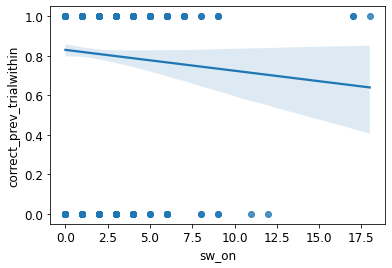

In [59]:
sns.regplot(data=var_per_trial_all_with_correct,x='sw_on',y='correct_prev_trialwithin')

# glm

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statannotations.Annotator import Annotator
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM
import re

In [13]:
var_per_trial_pos_all['speed_cat']=pd.cut(var_per_trial_pos_all['speed_gauss_mean'],[1,5,10,15,20],labels=False)

NameError: name 'var_per_trial_pos_all' is not defined

In [228]:
X = var_per_trial_pos_all.dropna(axis=0)
# X=X.loc[X.index.get_level_values(0)!='e13_16f1']

ani_l = var_per_trial_pos_all['animal'].unique()
ii=1
ani=ani_l[ii]
print(ani)
# print(ani)
# X=X.loc[ani]

e13_26m1


In [229]:
k_l=['sw_on_div_n_field','E_mean','I_mean','trial_z','speed_z']
X.loc[ani].rcorr().loc[k_l,k_l]
# X.loc[ani].pcorr().loc[k_l,k_l]

,sw_on_div_n_field,E_mean,I_mean,trial_z,speed_z
sw_on_div_n_field,-,0.122,0.032,-0.106,0.035
E_mean,**,-,***,***,***
I_mean,,-0.138,-,,***
trial_z,**,0.152,0.0,-,0.106
speed_z,,0.264,0.129,**,-


In [230]:
y_key='sw_on'#'sw_off'#
formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z+speed_cv_z+correct+correct_prev_seperate"
# formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z+speed_cv_z+correct_prev_seperate+E_mean+I_mean+E_I_mean"
# formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+C(speed_cat)+speed_cv_z+correct_prev_seperate"
# formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z+speed_std_z+correct_prev_seperate"
# formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z+correct_prev_trialwithin"
model=smf.glm(formula=formula,data=X,family=sm.families.Poisson(sm.families.links.Log()))
res=model.fit()

In [71]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  sw_on   No. Observations:                 5131
Model:                            GLM   Df Residuals:                     5110
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3554.3
Date:                Wed, 10 Jan 2024   Deviance:                       4343.0
Time:                        02:04:27   Pearson chi2:                 6.01e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1909
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.2163      0.109    -11.183      0.000      -1.429      -1.003
C(animal)[T.e13_26m1]      0.0800      0.092      0.865      0.387      -0.101       0.261
C(animal)[T.e14_2m2]      -0.3361      0.170     -1.977      0.048      -0.669      -0.003
C(animal)[T.e14_2m3]      -0.9252      0.126     -7.354      0.000      -1.172      -0.679
C(animal)[T.e15_10m1]     -0.4482      0.154     -2.913      0.004      -0.750      -0.147
C(animal)[T.e15_13f1]      0.4400      0.096      4.579      0.000       0.252       0.628
C(animal)[T.e15_9f1]      -0.6783      0.124     -5.480      0.000      -0.921      -0.436
C(animal)[T.e16_1f1]      -1.0575      0.156     -6.786      0.000      -1.363      -0.752
C(animal)[T.e16_2m1]      -1.3381      0.384     -3.488      0.000      -2.090      -0.586
C(animal)[T.e16_3m1]      -0.1416      0.115     -1.230      0.219      -0.367       0.084
C(animal)[T.e16_3m2]       0.1372      0.104      1.321      0.187      -0.066       0.341
C(lin_binned_cat)[T.1]    -0.2531      0.102     -2.489      0.013      -0.452      -0.054
C(lin_binned_cat)[T.2]     0.0631      0.084      0.754      0.451      -0.101       0.227
C(lin_binned_cat)[T.3]     0.3079      0.094      3.279      0.001       0.124       0.492
C(lin_binned_cat)[T.4]    -0.7021      0.106     -6.592      0.000      -0.911      -0.493
n_field                    0.0096      0.001      6.625      0.000       0.007       0.012
trial_z                   -0.1571      0.028     -5.616      0.000      -0.212      -0.102
speed_z                    0.1336      0.038      3.560      0.000       0.060       0.207
speed_cv_z                -0.0162      0.035     -0.470      0.639      -0.084       0.052
correct                   -0.0083      0.061     -0.135      0.893      -0.129       0.112
correct_prev_seperate     -0.0069      0.062     -0.111      0.912      -0.128       0.114
==========================================================================================
"""

In [597]:
reload(basp)

<module 'behavior_and_switching_plot' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching_plot.py'>

In [76]:
ttest_res

,coef,std err,z,P>|z|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
1-0,-0.117779,0.123332,-0.954973,3.395911e-01,-0.359506,0.123948,0.711969,False
2-0,-0.202997,0.099986,-2.030260,4.233015e-02,-0.398965,-0.007029,0.194475,False
3-0,-0.289819,0.115995,-2.498543,1.247050e-02,-0.517165,-0.062473,0.084095,False
4-0,-0.626237,0.125139,-5.004345,5.605229e-07,-0.871505,-0.380970,0.000006,True
2-1,-0.085217,0.111418,-0.764844,4.443646e-01,-0.303593,0.133158,0.711969,False
3-1,-0.172040,0.116550,-1.476097,1.399177e-01,-0.400475,0.056395,0.452783,False
4-1,-0.508458,0.146647,-3.467234,5.258448e-04,-0.795880,-0.221036,0.004723,True
3-2,-0.086822,0.094548,-0.918288,3.584683e-01,-0.272134,0.098489,0.711969,False
4-2,-0.423241,0.130414,-3.245352,1.173056e-03,-0.678848,-0.167633,0.009346,True
4-3,-0.336418,0.147399,-2.282372,2.246740e-02,-0.625314,-0.047522,0.127456,False


In [11]:
annot_pairs_l = [['2-1','3-2','4-1'],['2-1','3-2','4-3','3-1','4-1','4-2']]
do_save_fig = False
figsize=(1.5,2)
figsize_narrow=(1,2)
for y_key,annot_pairs in zip(['sw_on','sw_off'],annot_pairs_l):
# y_key ='sw_on'
#     formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z"
    formula=f"{y_key}~C(lin_binned_cat)+n_field"
    model=smf.glm(formula=formula,data=X,family=sm.families.Poisson(sm.families.links.Log()))
    res=model.fit()
    print(res.summary())
    res_df=misc.summarize_statsmodels(res,drop_intercept=False)
    table_fn =f'{y_key}_regress_coef.csv'
    res_df.to_csv(os.path.join(figdir,table_fn))
    
    
    fitted_par = res.tvalues

    ma =np.logical_not(fitted_par.index.str.contains('animal') | fitted_par.index.str.contains('Intercept'))
    val=fitted_par.loc[ma]
    annot_data=val.to_frame().reset_index().reset_index().rename({'level_0':'ind','index':'regressor',0:'weight'},axis=1)

    ttest_res=res.t_test_pairwise('C(lin_binned_cat)').result_frame
    print(ttest_res)
    # ttest_res=ttest_res.loc[['2-1','3-2','4-1']]
    ttest_res=ttest_res.loc[annot_pairs]
    table_fn =f'{y_key}_regress_pos_ttest.csv'
    ttest_res.to_csv(os.path.join(figdir,table_fn))
    


    pairs=np.array([[int(i) for i in s.split('-')] for s in ttest_res.index])
    pairs = pairs - 1

    pos_ma=annot_data['regressor'].str.contains('lin')
    annot_data_pos = annot_data.loc[pos_ma]
    annot_data_non_pos = annot_data.loc[~pos_ma]

    fig,ax=plt.subplots(figsize=figsize_narrow)
    ncolors = len(segment_names)
    colors = [f'C{i}' for i in np.arange(ncolors)]
    colors = colors[1:]
    # ax=sns.barplot(x='ind',y='weight',data=annot_data_pos,color='C0',yerr=1.96,ax=ax)
    ax=sns.barplot(x='ind',y='weight',data=annot_data_pos,palette=colors,yerr=1.96,ax=ax)
    ax.axhline(0,color='k')
    pvalues = ttest_res['pvalue-hs']
    annotator = Annotator(ax, pairs, data=annot_data_pos,x='ind',y='weight')
    annotator.set_pvalues_and_annotate(pvalues)

    xticklabels=basp.refine_tick_labels(annot_data_pos['regressor'],lin_cat_map=None)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set(xlabel=None,ylabel='Regresssion coef. (z)\nrelative to Delay Zone')
    
    fn=f'{y_key}_regress_coef_bar_spatial.svg'
    if do_save_fig:
        fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')

    fig,ax=plt.subplots(figsize=figsize)
    ax=sns.barplot(x='ind',y='weight',data=annot_data_non_pos,color='grey',yerr=1.96,ax=ax)
    ax.axhline(0,color='k')
    xticklabels=basp.refine_tick_labels(annot_data_non_pos['regressor'],lin_cat_map=None)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set(xlabel=None,ylabel='Regresssion coef. (z)')

    fn=f'{y_key}_regress_coef_bar_non_spatial.svg'
    if do_save_fig:
        fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')


NameError: name 'smf' is not defined

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sw_on   No. Observations:                 4526
Model:                            GLM   Df Residuals:                     4505
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3125.7
Date:                Wed, 10 Jan 2024   Deviance:                       3809.1
Time:                        20:16:30   Pearson chi2:                 5.28e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1949
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

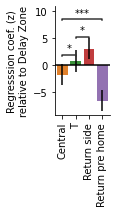

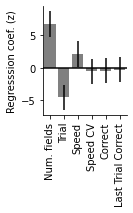

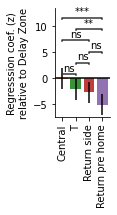

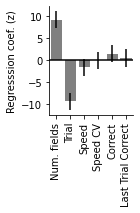

In [285]:
annot_pairs_l = [['2-1','3-2','4-1'],['2-1','3-2','4-3','3-1','4-1','4-2']]
do_save_fig = True
figsize=(1.5,2)
figsize_narrow=(1,2)
for y_key,annot_pairs in zip(['sw_on','sw_off'],annot_pairs_l):
# y_key ='sw_on'
#     formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z"
    formula=f"{y_key}~C(animal)+C(lin_binned_cat)+n_field+trial_z+speed_z+speed_cv_z+correct+correct_prev_seperate"
    model=smf.glm(formula=formula,data=X,family=sm.families.Poisson(sm.families.links.Log()))
    res=model.fit()
    print(res.summary())
    res_df=misc.summarize_statsmodels(res,drop_intercept=False)
    table_fn =f'{y_key}_regress_coef.csv'
    res_df.to_csv(os.path.join(figdir,table_fn))
    
    
    fitted_par = res.tvalues

    ma =np.logical_not(fitted_par.index.str.contains('animal') | fitted_par.index.str.contains('Intercept'))
    val=fitted_par.loc[ma]
    annot_data=val.to_frame().reset_index().reset_index().rename({'level_0':'ind','index':'regressor',0:'weight'},axis=1)

    ttest_res=res.t_test_pairwise('C(lin_binned_cat)').result_frame
    print(ttest_res)
    # ttest_res=ttest_res.loc[['2-1','3-2','4-1']]
    ttest_res=ttest_res.loc[annot_pairs]
    table_fn =f'{y_key}_regress_pos_ttest.csv'
    ttest_res.to_csv(os.path.join(figdir,table_fn))
    


    pairs=np.array([[int(i) for i in s.split('-')] for s in ttest_res.index])
    pairs = pairs - 1

    pos_ma=annot_data['regressor'].str.contains('lin')
    annot_data_pos = annot_data.loc[pos_ma]
    annot_data_non_pos = annot_data.loc[~pos_ma]

    fig,ax=plt.subplots(figsize=figsize_narrow)
    ncolors = len(segment_names)
    colors = [f'C{i}' for i in np.arange(ncolors)]
    colors = colors[1:]
    # ax=sns.barplot(x='ind',y='weight',data=annot_data_pos,color='C0',yerr=1.96,ax=ax)
    ax=sns.barplot(x='ind',y='weight',data=annot_data_pos,palette=colors,yerr=1.96,ax=ax)
    ax.axhline(0,color='k')
    pvalues = ttest_res['pvalue-hs']
    annotator = Annotator(ax, pairs, data=annot_data_pos,x='ind',y='weight')
    annotator.set_pvalues_and_annotate(pvalues)

    xticklabels=basp.refine_tick_labels(annot_data_pos['regressor'],lin_cat_map=None)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set(xlabel=None,ylabel='Regresssion coef. (z)\nrelative to Delay Zone')
    
    fn=f'{y_key}_regress_coef_bar_spatial.svg'
    if do_save_fig:
        fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')

    fig,ax=plt.subplots(figsize=figsize)
    ax=sns.barplot(x='ind',y='weight',data=annot_data_non_pos,color='grey',yerr=1.96,ax=ax)
    ax.axhline(0,color='k')
    xticklabels=basp.refine_tick_labels(annot_data_non_pos['regressor'],lin_cat_map=None)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set(xlabel=None,ylabel='Regresssion coef. (z)')

    fn=f'{y_key}_regress_coef_bar_non_spatial.svg'
    if do_save_fig:
        fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')


# regression selection

In [232]:
reload(bas)
key_l = np.array(['animal','lin_binned_cat','n_field','trial_z','speed_z','speed_cv_z','correct','correct_prev_seperate'])
# cat_l = np.array([True,True,False,False,False,False,False])
cat_l = np.array([True,True,False,False,False,False,True,True])
# combo_l = [[0,1,2,3,4,5],[0,1,2,3,4],[0,1,2,3],[0,1,2],[0,1,3],[0,2,3],[0,1],[0,2]]#None#[[0,1,2,3,4],[0,1,2,3],[1,2,4],[1,2],[1]]
nkey = len(key_l)
combo_l=[np.arange(nkey)]
for i in range(nkey):
    combo=np.concatenate([np.arange(i),np.arange(i+1,nkey)])
    combo_l.append(combo)

# combo_l = [[0,1,2,3,4],[0,1,2,3],[0,1,2,4],[0,1,3,4],[0,2,3,4],[1,2,3,4]]
# formula_shorthand = ['Full','w/o Speed','w/o Trial','w/o N field','w/o Position','w/o Animal']
formula_shorthand = ['Full','w/o Animal','w/o Position','w/o N field','w/o Trial','w/o Speed','w/o Speed CV','w/o Correct','w/o Correct Prev. Trial']
y_key = 'sw_on'
formula_l=bas.build_formula_multiple(key_l,cat_l,y_key,combo_l=combo_l)


In [233]:
%%time
reload(bas)
X = var_per_trial_pos_all.dropna(axis=0)
sc_l_all_l_d = {}
for y_key in ['sw_on','sw_off']:
    formula_l=bas.build_formula_multiple(key_l,cat_l,y_key,combo_l=combo_l)

    n_splits = 5
    n_repeats = 10
    sc_l_all_l = []
    # X = var_per_trial_pos_all.loc[ani_l]
#     X = var_per_trial_pos_all
    for n in range(n_repeats):
        sc_l_all,res_all=bas.cv_poisson_glm_multi_formula(X,formula_l,n_splits=n_splits,random_state=n)
        sc_l_all_l.append(np.median(sc_l_all,axis=1))
    if formula_shorthand is not None:
        index=formula_shorthand
    else:
        index=formula_l
    sc_l_all_l = pd.DataFrame(np.array(sc_l_all_l).T,index=index)
    sc_l_all_l_d[y_key] = sc_l_all_l
# sc_multirep_median=np.median(np.array(sc_l_all_l),axis=0)
# score_df=pd.Series(sc_multirep_median,index=formula_l)
sc_l_all_l_d=pd.concat(sc_l_all_l_d,axis=0)

CPU times: user 3min 52s, sys: 2.71 s, total: 3min 55s
Wall time: 59.3 s


In [262]:
# scipy.stats.wilcoxon(sc_l_all_l_d.loc['sw_on','Full'],sc_l_all_l_d.loc['sw_on','w/o Trial'],alternative='greater')
# # scipy.stats.wilcoxon(sc_l_all_l_d.loc['sw_on','Full'],sc_l_all_l_d.loc['sw_on','w/o Correct'],alternative='greater')



WilcoxonResult(statistic=138.0, pvalue=0.11525630950927734)

In [264]:
# key = 'w/o Trial'#'w/o Position'#
# xx=sc_l_all_l_d.loc['sw_on','Full'] - sc_l_all_l_d.loc['sw_on',key]
# xx.mean() / xx.std()

0.20413742788375197

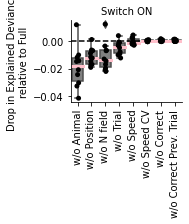

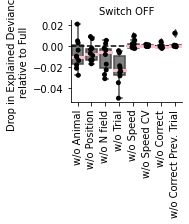

In [284]:
y_key = 'sw_on'
formula_shorthand_nofull = [x for x in formula_shorthand if x!='Full']
for onoff_str in ['on','off']:
    y_key = f'sw_{onoff_str}'
    
    diff=sc_l_all_l_d.loc[y_key].loc[formula_shorthand_nofull]-sc_l_all_l_d.loc[y_key,'Full']
    eff_sz = diff.mean(axis=1) / diff.std(axis=1)
    
    toplot = diff
    fig,ax=plt.subplots(figsize=(2,1.5))
    ax=sns.boxplot(data=toplot.T,color='grey',ax=ax,medianprops=dict(color="pink",linewidth=3))
    ax=sns.stripplot(data=toplot.T,color='k',ax=ax)
    # toplot.plot(legend=False,linestyle=':',color='k',ax=ax)
    ax.set(ylabel='Drop in Explained Deviance\nrelative to Full')
    xticklabels=ax.get_xticklabels()
    ax.set_xticklabels(xticklabels,fontsize=10,rotation=90)
    ax.set_title(f'Switch {onoff_str.upper()}')
    ax.axhline(0,c='k',linestyle='--')
#     fn=f'held_out_d2_vs_model_{y_key}.svg'
    fn=f'held_out_d2_decrease_vs_model_{y_key}.svg'
    fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')
    sns.despine()

# behavior variability, EI, arm difference

In [613]:
var_per_trial_pos_all

trial  lin_binned_cat  speed_gauss_mean  \
                         task_index                                            
e13_16f1 e13_16f1_210302 0             4.0               0          3.651214   
                         0             4.0               1          6.243967   
                         0             4.0               2          5.085595   
                         0             4.0               3          3.995462   
                         0             4.0               4          3.700580   
...                                    ...             ...               ...   
e16_3m2  e16_3m2_211213  0            26.0               0          6.034539   
                         0            26.0               1          7.388164   
                         0            26.0               2         10.247094   
                         0            26.0               3          5.821348   
                         0            26.0               4          6.402528   

                                     speed_gauss_std  speed_gauss_cv  \
                         task_index                                    
e13_16f1 e13_16f1_210302 0                  2.375648        0.650646   
                         0                  2.603304        0.416931   
                         0                  2.413563        0.474588   
                         0                  2.598270        0.650305   
                         0                  2.746139        0.742083   
...                                              ...             ...   
e16_3m2  e16_3m2_211213  0                  3.024823        0.501252   
                         0                  4.082589        0.552585   
                         0                  4.266651        0.416377   
                         0                  4.098061        0.703971   
                         0                  3.723784        0.581611   

                                       E_mean    I_mean  E_I_mean  \
                         task_index                                 
e13_16f1 e13_16f1_210302 0           0.055191  0.580113  0.095139   
                         0           0.051918  0.596400  0.087053   
                         0           0.057441  0.606739  0.094672   
                         0           0.066086  0.556405  0.118774   
                         0           0.049795  0.516396  0.096428   
...                                       ...       ...       ...   
e16_3m2  e16_3m2_211213  0           0.047608  0.526035  0.090503   
                         0           0.033361  0.463909  0.071912   
                         0           0.042358  0.487945  0.086809   
                         0           0.042085  0.445787  0.094406   
                         0           0.056497  0.575984  0.098087   

                                     E_frac_active  I_frac_active  ...  \
                         task_index                                ...   
e13_16f1 e13_16f1_210302 0                0.043246       0.372702  ...   
                         0                0.041898       0.417151  ...   
                         0                0.045784       0.402213  ...   
                         0                0.051693       0.375494  ...   
                         0                0.039290       0.354149  ...   
...                                            ...            ...  ...   
e16_3m2  e16_3m2_211213  0                0.038811       0.328228  ...   
                         0                0.026962       0.299064  ...   
                         0                0.034729       0.300988  ...   
                         0                0.033039       0.285683  ...   
                         0                0.045417       0.360583  ...   

                                     speed_std_z  speed_cv_z   trial_z  \
                         task_index                                      
e13_16f1 e13_16f1_210302 0             -0.872559  

In [18]:
beh_var_l = ['task_index','trial_type','trial','time','lin','lin_binned','speed_gauss','v_gauss','off_track_event','pause_event','directed_locomotion']
beh_df_all = spk_beh_df_all[beh_var_l]
task_index = 0
# filter df, only keep task_index==0, and directed_locomotion
beh_df_all_fam = beh_df_all.query('(task_index==@task_index)')

# assign categorical variables
var_bin_d_default = {'lin_binned':np.array([0,15,74,111,185,202,222])/2.2}
var_bin_d = var_bin_d_default
lin_binned_cat_max = len(var_bin_d['lin_binned'])-2
beh_df_all_fam = bas.get_categorical_var(beh_df_all_fam,var_bin_d)

combine_first_last_section = True
# update lin cat, combine two home region
if combine_first_last_section:
    beh_df_all_fam.loc[beh_df_all_fam['lin_binned_cat']==lin_binned_cat_max,'lin_binned_cat'] = 0

/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k_cat] = pd.cut(df[k],val,retbins=False,labels=False,include_lowest=True)


In [19]:
gpb=beh_df_all_fam.set_index(['lin_binned_cat','trial'],append=True).groupby(level=(0,1,3,4))

speed_per_pos_trial = pd.concat({'mean':gpb['speed_gauss'].mean(),'std':gpb['speed_gauss'].std()},axis=1)
islocomotion_per_pos_trial = pd.concat({'mean':gpb['directed_locomotion'].mean(),'std':gpb['directed_locomotion'].std()},axis=1)

In [20]:
speed_per_pos_trial['cv'] = speed_per_pos_trial['mean'] / speed_per_pos_trial['std']

In [21]:
speed_per_pos_trial['islocomotion'] = islocomotion_per_pos_trial['mean']

In [633]:
# def entropy(x):
#     eps=1e-10
#     return -np.sum(x*np.log(x+eps))
# event_l = ['off_track_event','pause_event','directed_locomotion']
# beh_entropy_all={}
# for k,val in gpb:
#     beh_entropy_all[k]=entropy(val[event_l].mean(axis=0))
# beh_entropy_all = pd.Series(beh_entropy_all,name='entropy')

In [643]:
toplot

,lin_binned_cat,mean,std,cv,islocomoation
0,0,4.890157,3.911690,1.237336,0.669461
1,1,5.120462,4.345772,1.193917,0.559095
2,2,3.032771,2.976955,0.967621,0.355333
3,3,2.684940,3.251131,0.838942,0.351839
4,4,6.053197,2.820134,2.691213,0.643225
...,...,...,...,...,...
225,0,5.521009,3.999872,1.446534,0.682390
226,1,12.026857,5.490977,2.486678,0.868718
227,2,4.565371,3.953689,1.151821,0.467746
228,3,5.573224,4.748973,1.171260,0.538348


In [656]:
segment_names =['delay zone','central','T','return side','return pre delay zone']

In [22]:
toplot = speed_per_pos_trial.groupby(level=(0,1,2)).mean().reset_index(level=2).reset_index(drop=True)

In [25]:
speed_per_pos_trial.groupby(level=(0,1,2)).mean().loc[(slice(None),'e13_16f1_210302'),:]

mean       std        cv  \
                         lin_binned_cat                                 
e13_16f1 e13_16f1_210302 0               4.890157  3.911690  1.237336   
                         1               5.120462  4.345772  1.193917   
                         2               3.032771  2.976955  0.967621   
                         3               2.684940  3.251131  0.838942   
                         4               6.053197  2.820134  2.691213   

                                         islocomotion  
                         lin_binned_cat                
e13_16f1 e13_16f1_210302 0                   0.669461  
                         1                   0.559095  
                         2                   0.355333  
                         3                   0.351839  
                         4                   0.643225

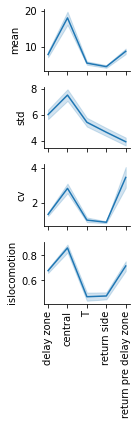

In [114]:
# this analysis no filter beforehand!
toplot = speed_per_pos_trial.groupby(level=(0,1,2)).mean().reset_index(level=2).reset_index(drop=True)

k_l = ['mean','std','cv','islocomotion']
# k_l = ['E_mean','I_mean','E_I_mean']
nplots=len(k_l)
fig,axs=plt.subplots(nplots,1,figsize=(2,1.5*nplots),sharex=True)
for ii,y in enumerate(k_l):
    ax=axs[ii]
    ax=sns.lineplot(data=toplot,x='lin_binned_cat',y=y,ax=ax)  
    ax.set_xlabel("")
    ax.set_xticks(np.arange(len(segment_names)))
    ax.set_xticklabels(segment_names,rotation=90)
plt.tight_layout()

figfn='speed_var_vs_arm'
ph.save_given_name(fig,figfn,figdir=figdir)

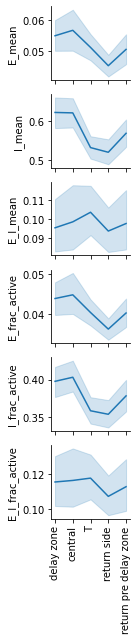

In [116]:
# for firing related analysis, there is behavioral filter!
var_per_pos = var_per_trial_pos_all.set_index(['lin_binned_cat'],append=True).groupby(level=(0,1,3)).mean()
toplot=var_per_pos.reset_index(level=2).reset_index(drop=True)
k_l = ['E_mean','I_mean','E_I_mean','E_frac_active','I_frac_active','E_I_frac_active']
nplots=len(k_l)
fig,axs=plt.subplots(nplots,1,figsize=(2,1.5*nplots),sharex=True)
for ii,y in enumerate(k_l):
    ax=axs[ii]
    ax=sns.lineplot(data=toplot,x='lin_binned_cat',y=y,ax=ax)  
    ax.set_xlabel("")
    ax.set_xticks(np.arange(len(segment_names)))
    ax.set_xticklabels(segment_names,rotation=90)
plt.tight_layout()
figfn='ei_vs_arm'
ph.save_given_name(fig,figfn,figdir=figdir)

# spatial within animal

In [17]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

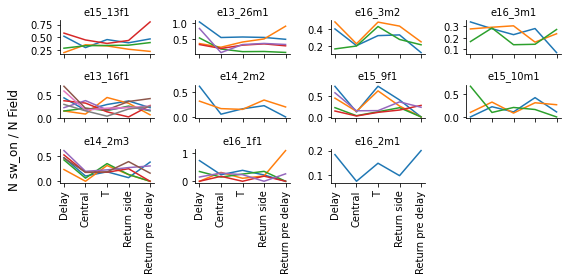

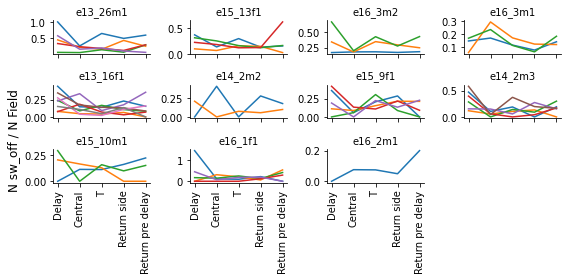

In [235]:
# y_key = 'sw_on'
matplotlib.rcParams['font.size']=10
for y_key in ['sw_on','sw_off']:
    ani_sorted=var_per_pos.groupby(level=0)[y_key].mean().sort_values(ascending=False).index

    gpb=var_per_pos.groupby(level=0)
    nplots=len(gpb)
    fig,axs=ph.subplots_wrapper(nplots,figsize=(8,4),sharex=True)
    for ax in axs.ravel():
        ax.set_axis_off()
    # for ii,(ani,val) in enumerate(gpb):
    for ii, ani in enumerate(ani_sorted):
        val = gpb.get_group(ani)
        ax=axs.ravel()[ii]
        ax.set_axis_on()
        sns.lineplot(data=val.reset_index(),x='lin_binned_cat',y=f'{y_key}_div_n_field',ax=ax,hue='level_1',legend=None)
        ax.set_title(ani)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels(['Delay','Central','T','Return side','Return pre delay'],rotation=90)
    fig.supylabel(f'N {y_key} / N Field')
    plt.tight_layout()

    fn = f'{y_key}_div_n_field_vs_lin_binned_cat_all_ani'
    ph.save_given_name(fig,fn,figdir)
#     fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')
matplotlib.rcParams['font.size']=10

# vs trial

In [269]:
reload(bas)

<module 'behavior_and_switching' from '/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py'>

In [270]:
# y_key_l = ['sw_on','sw_off','sw_on_div_n_field','sw_off_div_n_field','n_field']
# var_per_trial=var_per_trial_pos_all.groupby(level=(0,1,2)).apply(lambda x:x.groupby('trial')[y_key_l].sum())
# to_add= var_per_trial_pos_all.groupby(level=(0,1,2)).apply(lambda x:x.groupby('trial')[['trial_z','speed_z']].mean())
# var_per_trial =pd.concat([var_per_trial ,to_add],axis=1)

var_per_trial = bas.agg_within_trial(var_per_trial_pos_all)
# var per trial pos for NOVEL!
reload(bas)
# var_bin_d = {'lin_binned':np.array([0,15,44.5,74,92.5,111,148,185,202,222])/2.2} # doesn't really matter here since we only look at trial here, but kept for testing if it actually doesn't matter
var_bin_d = {'lin_binned':np.array([0,15,74,111,185,222])/2.2} # doesn't really matter here since we only look at trial here, but kept for testing if it actually doesn't matter
var_per_trial_pos_all_novel=bas.prep_regression(spk_beh_df_all,all_fields_recombined_all,all_sw_d_all,trial_index_to_index_within_df_all,task_index=1,var_bin_d=var_bin_d)


reload(bas)
var_per_trial_novel = bas.agg_within_trial(var_per_trial_pos_all_novel)

/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k_cat] = pd.cut(df[k],val,retbins=False,labels=False,include_lowest=True)
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.
  if 'both' in all_fields_recombined_all.loc[(ani,sess,ti),:].index.get_level_values(0):
/mnt/home/szheng/projects/place_variability/code/behavior_and_switching.

In [271]:
var_per_trial.shape

(1029, 7)

In [272]:
var_per_trial_novel.shape

(281, 7)

In [35]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

sw_on_div_n_field
familiar
r=-0.15
p=1.3e-06
sw_on_div_n_field
novel
r=-0.23
p=1.3e-04
sw_off_div_n_field
familiar
r=-0.20
p=3.3e-11
sw_off_div_n_field
novel
r=-0.18
p=2.7e-03
speed_z
familiar
r=0.01
p=7.2e-01
speed_z
novel
r=-0.02
p=7.8e-01


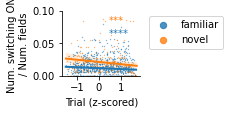

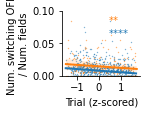

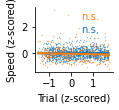

In [275]:
# for y_key in ['sw_on','sw_off']:
xlabel = 'Trial (z-scored)'
ylabel_l=['Num. switching ON \n/ Num. fields','Num. switching OFF \n/ Num. fields','Speed (z-scored)']

for ii,y_key in enumerate(['sw_on_div_n_field','sw_off_div_n_field','speed_z']):
    fig,ax=plt.subplots(figsize=(1.4,1.2))
    for jj,(toplot,label) in enumerate(zip([var_per_trial,var_per_trial_novel],['familiar','novel'])):
        toplot = toplot.fillna(0)
        ax=sns.regplot(data=toplot,x='trial_z',y=y_key,line_kws={'linewidth':2},scatter_kws={'s':0.1},ax=ax,label=label)
        ylabel = ylabel_l[ii]
        ax.set(ylabel=ylabel,xlabel=xlabel)

        rho,pval=scipy.stats.spearmanr(toplot['trial_z'],toplot[y_key])
        print(y_key)
        print(label)
        star=ph.star_map(pval)
        r_str=f'r={rho:.02f}\np={pval:.01e}'
        print(r_str)
        ax.annotate(star,xy=(0.6,0.6+0.2*jj),xycoords='axes fraction',color=f'C{jj}')
        sns.despine()
    if ii==0:
        ax.legend(markerscale=20,bbox_to_anchor=[1.05,1])
    if ii<=1:
        ax.set_ylim([0,0.1])

    fn = f'{y_key}_vs_trial_z_fam_novel'
    ph.save_given_name(fig,fn,figdir)
#     fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')




# switch vs speed 

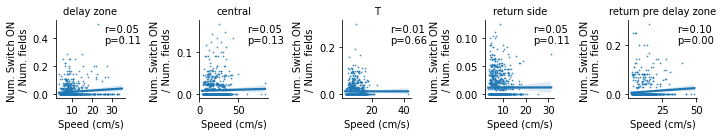

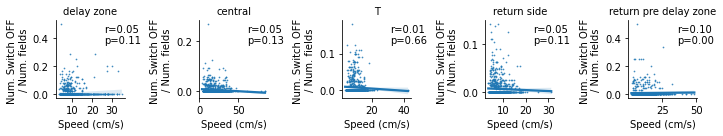

In [281]:
gpb=var_per_trial_pos_all.groupby('lin_binned_cat')

for onoff_str in ['on','off']:
# onoff_str = 'on'
    fig,axs=plt.subplots(1,5,figsize=(2*5,2))
    for ii,(k,val) in enumerate(gpb):
        ax=axs.ravel()[ii]
        val = val.fillna(0)
        sns.regplot(data=val,x='speed_gauss_mean',y=f'sw_{onoff_str}_div_n_field',ax=ax,scatter_kws={'s':0.5}) # show actual speed, compute rho using z scored within session?
    #     rho,pval=scipy.stats.pearsonr(val['speed_z'],val['sw_on_div_n_field'])
        rho,pval=scipy.stats.spearmanr(val['speed_z'],val['sw_on_div_n_field'])
        r_str=f'r={rho:.02f}\np={pval:.02f}'
        ax.annotate(r_str,xy=(0.7,0.7),xycoords='axes fraction')
        ax.set_title(segment_names[ii])
        ax.set_ylabel(f'Num. Switch {onoff_str.upper()} \n/ Num. fields')
        ax.set(xlabel='Speed (cm/s)')
    plt.tight_layout()

    fn = f'sw_{onoff_str}_div_n_field_vs_speed_seperate_lin_binned_cat'
    ph.save_given_name(fig,fn,figdir)
#     fig.savefig(os.path.join(figdir,fn),bbox_inches='tight')

# funny behavior map

In [286]:
# get the x y for all switches, one location counted once per trial
from scipy.interpolate import interp1d

task_index=0
all_sw_d_all_fam = all_sw_d_all.loc[(slice(None),slice(None),task_index)]
all_sw_gpb = all_sw_d_all_fam.groupby(level=(0,1))


all_sw_xy_d_all = {}
for k,all_sw_sub in all_sw_gpb:
    data = spk_beh_df_all.loc[k].query('task_index==@task_index')
    lin_to_xy_trial =data.groupby('trial').apply(lambda x:interp1d(x['lin_binned'].values,x[['x','y']].values,axis=0,fill_value='extrapolate'))
    gpb =  all_sw_sub.groupby('trial_index')
    all_sw_xy_d = {}
    for onoff in [1,-1]:
        all_sw_xy = []
        for tr, val in gpb:
            lin_one_trial = np.unique(val.query('switch==@onoff')['field_pos'].values)
            if len(lin_one_trial)>0:
                xy = lin_to_xy_trial.loc[tr](lin_one_trial+0.00001)
                all_sw_xy.extend(xy)
        all_sw_xy_d[onoff] = pd.DataFrame(np.array(all_sw_xy),columns=['x','y'])
    all_sw_xy_d = pd.concat(all_sw_xy_d,axis=1)
    all_sw_xy_d_all[k] =all_sw_xy_d 
all_sw_xy_d_all = pd.concat(all_sw_xy_d_all,axis=0)
            

/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpola

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = spk_beh_df_all.loc[k].query('task_index==@task_index')
/tmp/ipykernel_1216702/3871266608.py:11: PerformanceWarning: indexing past lexsort dept

In [287]:
reload(bas)
import behavior_analysis as ba
reload(ba)


# get headscan positions!!!
# only keep one per trial & position
beh_cols = spk_beh_df_all.columns.str.isnumeric()==False
beh_df_all = spk_beh_df_all.loc[:,beh_cols]

beh_df_all_fam = beh_df_all.query('task_index==0')
headscan_info_all=ba.get_event_start_info_all_sess(beh_df_all_fam,event_key='off_track_event',drop_multiple=True)

/tmp/ipykernel_1216702/2822768486.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  data= spk_beh_df_all.loc[ani,sess].query('task_index==@task_index')


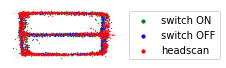

In [294]:

fig,ax=plt.subplots(figsize=(2,1))
ani,sess = 'e13_26m1','e13_26m1_210913'
task_index = 0
data= spk_beh_df_all.loc[ani,sess].query('task_index==@task_index')
# data= spk_beh_df_all.query('task_index==@task_index') # use this is slow!!
ax.plot(data['x'].values[::10],data['y'].values[::10],c='grey',alpha=0.1)

c_l = ['g','b']
onoff_str_d = {1:'switch ON',-1:'switch OFF'}
for onoff,c in zip([1,-1],c_l):
    ax.scatter(all_sw_xy_d_all[onoff,'x'],all_sw_xy_d_all[onoff,'y'],marker='o',c=c,s=0.1,label=onoff_str_d[onoff])
ax.scatter(headscan_info_all['x'],headscan_info_all['y'],marker='o',c='r',s=0.1,label='headscan')
plt.axis('off')
legend = ax.legend(markerscale=10,bbox_to_anchor=[1.05,1])

fn = 'switch_and_headscan_on_maze_small'
# fn_full = os.path.join(figdir,fn)
ph.save_given_name(fig,fn,figdir,dpi=900)
# fig.savefig(fn_full,bbox_inches='tight')

# quantifying ratio of switching and headscan

In [295]:
segment_edges=np.array([0,15,74,111,185,202,222])/2.2
# segment_names =['home','central','T','return side','return pre home','home']
segment_names =['delay zone','central','T','return side','return pre delay zone','delay zone']


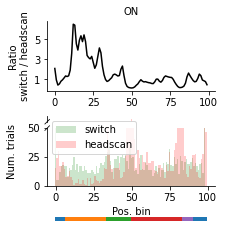

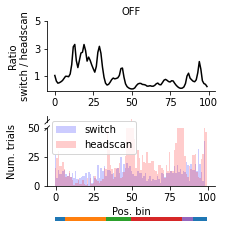

In [297]:
from scipy.ndimage import gaussian_filter1d
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
lin_binned_bins = np.arange(-0.5,100.5,1.)

headscan_pos = headscan_info_all['lin_binned'].values
headscan_ct,_ = np.histogram(headscan_pos,bins=lin_binned_bins)
headscan_ct_smth = gaussian_filter1d(headscan_ct.astype(float),1)
sw_count_div_headscan_count_d = {}
sw_count_per_bin_d = {}

fs=10
onoff_str_d = {1:'ON',-1:'OFF'}
c_l = ['g','b']
for ii,(onoff,c) in enumerate(zip([1,-1],c_l)):
    
    fig = plt.figure(figsize=(3,3))
    sps_l,sps,sps_c = GridSpec(3,1,height_ratios=[2,2,0.1])
    ax = bax = brokenaxes(ylims=((0, 50), (240, 245)), hspace=.2,subplot_spec=sps)
    axl = fig.add_subplot(sps_l)
    cax = fig.add_subplot(sps_c)
    
    pos = all_sw_d_all_fam.query('switch==@onoff')['field_pos']
    ct,_ = np.histogram(pos,bins=lin_binned_bins)
    ct_smth = gaussian_filter1d(ct.astype(float),1)
    sw_count_per_bin_d[onoff] = ct
    sw_count_div_headscan_count_d[onoff] = ct_smth / headscan_ct_smth

    ax.hist(pos,bins=lin_binned_bins,color=c,alpha=0.2,label='switch')
    ax.hist(headscan_pos,bins=lin_binned_bins,color='r',alpha=0.2,label='headscan')
    ax.set_ylabel('Num. trials',fontsize=fs)
    ax.axs[1].set_xlabel('Pos. bin',fontsize=fs)    
    
    axl.plot(sw_count_div_headscan_count_d[onoff],color='k',label='ratio')
    axl.set_yticks(range(1,7,2))
    axl.set_ylabel('Ratio\nswitch / headscan',fontsize=fs)
    axl.set_title(onoff_str_d[onoff],fontsize=fs)
    pos1=axl.get_position()
    axl.set_position([pos1.x0,pos1.y0+0.07,pos1.width,pos1.height])
    
    ax.legend(loc='upper left')
    
    ax=cax
    n_segments = len(np.unique(segment_names)) # first and last the same
    for ii,(st,ed) in enumerate(zip(segment_edges[:-1],segment_edges[1:])):    
        ii=ii%n_segments
        ax.axvspan(st,ed,facecolor=f'C{ii}')
    ax.axis('off')
    pos1=ax.get_position()
    ax.set_position([pos1.x0,pos1.y0-0.1,pos1.width,pos1.height])

    fn = f'switch_div_headscan_n_trials_vs_lin_binned_{onoff}'
    ph.save_given_name(fig,fn,figdir)
#     fn_full=os.path.join(figdir,fn)
#     fig.savefig(fn_full,bbox_inches='tight')


/tmp/ipykernel_1216702/1327229917.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  data= spk_beh_df_all.loc[ani,sess].query('task_index==@task_index')


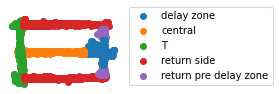

In [308]:
# maze schematic
ani,sess = 'e13_26m1','e13_26m1_210913'
task_index = 0
data= spk_beh_df_all.loc[ani,sess].query('task_index==@task_index')
# data= spk_beh_df_all.query('task_index==@task_index') # use this is slow!!
n_segments = len(np.unique(segment_names)) # first and last the same
fig,ax=plt.subplots(figsize=(2,1.3))
for ii,(st,ed) in enumerate(zip(segment_edges[:-1],segment_edges[1:])):    
    ii=ii%n_segments
    ma = (data['lin_binned']>=st)&(data['lin_binned']<ed)
    ax.scatter(data.loc[ma]['x'].values[::10],data.loc[ma]['y'].values[::10],c=f'C{ii}',alpha=1)
ax.legend(segment_names[:-1],bbox_to_anchor=[1.05,1.2])
ax.axis('off')

fn = 'maze_arm_colored.svg'
# fn_full = os.path.join(figdir,fn)
# fig.savefig(fn_full,bbox_inches='tight')
ph.save_given_name(fig,fn,figdir,dpi=900)

# plot headscan

In [309]:
data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][19] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="IZ33_580um_210315_sess9"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_10m1_200727"')['data_dir_full'][0]



# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [310]:
reload(dpp)
beh_df=dpp.get_multi_maze_behavior_df(behavior)
beh_df = beh_df.reset_index()

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [311]:
import behavior_analysis as ba
reload(ba)
beh_df = ba.detect_offtrack_event(beh_df,find_turns_kws={},off_track_thresh = 4.,
            on_track_thresh = 1,edges_merge_time=0.4,st_ed_dist_thresh = 20.)


beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event'],
                        speed_key='speed_gauss',speed_thresh=1.,
                        compare_type='<=',
                        edges_merge_time = None,
                        event_key = 'pause_event',
                        )

beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event','pause_event'],
                        speed_key='v_gauss',speed_thresh=1.,
                        compare_type='>',
                        edges_merge_time = None,
                        event_key = 'directed_locomotion',
                        )

beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event','pause_event','directed_locomotion'],
                        speed_key='speed_gauss',speed_thresh=[1,5],
                        compare_type='between',
                        edges_merge_time = None,
                        event_key = 'low_speed',
                        )

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


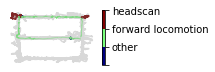

In [324]:
import behavior_analysis as ba
reload(ba)
beh_df_sub = beh_df.query('task_index==0')
# ax = axs.ravel()[ii]
tr=6
one_chunk = beh_df_sub.query('trial==@tr')
# colors =  one_chunk['pause_event'].astype(int) * 1 + one_chunk['low_speed'].astype(int) * 2 +  \
#         one_chunk['directed_locomotion'].astype(int) * 3 + one_chunk['off_track_event'].astype(int)  * 4

colors = one_chunk['directed_locomotion'].astype(int) * 1 + one_chunk['off_track_event'].astype(int)  * 2


fig,ax,cbar=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,cmin=0,cmax=2,color_discrete=True,
                        cbar_tick_labels=['','other','forward locomotion','headscan'],fig=None,ax=None,
                                 figsize=(2,1)
                       )
cbar.ax.tick_params(labelsize=10)
ax.axis('off')
figfn = 'headscan_schematic'
ph.save_given_name(fig,figfn,figdir=figdir,dpi=900)